# Optimización de Redes - Creación de Redes Inalambricas

In [36]:
from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverFactory
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv


### Estudiantes:  
* Laura Julieth Carretero Serrano - 202214922  
* Juan David Rios Nisperuza - 202215787

# Problema 1: Redes de Transporte

## a. Modelo Matematico:

#### Conjuntos:
$$P = \{1, 2\}$$
Conjunto de **proveedores** o ciudades distribuidoras, donde 1 es Bogotá y 2 es Medellín.

$$D = \{1, 2, 3, 4, 5, 6\}$$
Conjunto de **destinos**, que son las ciudades de Cali, Barranquilla, Pasto, Tunja, Chía y Manizales.

### Parámetros:
- **Costo de transporte por tonelada**:
  $$\text{cost}_{ij} = \text{Costo de transporte desde la ciudad } i \text{ hacia la ciudad } j, \ \forall i \in P, j \in D$$
  
  Matriz de costos:
  $$
  \text{cost} = \begin{bmatrix}
  999 & 2.5 & 1.6 & 1.4 & 0.8 & 1.4 \\
  2.5 & 999 & 2.0 & 1.0 & 1.0 & 0.8
  \end{bmatrix}
  $$
  
- **Oferta disponible por proveedor**:
  $$\text{oferta}_i = \text{Oferta disponible en la ciudad } i, \ \forall i \in P$$
  
  Vector de oferta:
  $$
  \text{oferta} = \{550, 700\}
  $$

- **Demanda por destino**:
  $$\text{precioDemanda}_j = \text{Demanda de productos en la ciudad } j, \ \forall j \in D$$
  
  Vector de demanda:
  $$
  \text{precioDemanda} = \{125, 175, 225, 250, 225, 200\}
  $$

### Variables de Decisión:
$$x_{ij} = \text{Cantidad de toneladas enviadas desde la ciudad } i \text{ a la ciudad } j, \ \forall i \in P, \forall j \in D$$

### Función Objetivo:
Minimizar el **costo total de transporte**:
$$\text{Minimizar} \quad \sum_{i \in P} \sum_{j \in D} x_{ij} \times \text{cost}_{ij}$$

### Restricciones:

1. **Restricciones de suministro**:
La cantidad enviada desde cada proveedor no puede exceder su oferta:
$$\sum_{j \in D} x_{ij} \leq \text{oferta}_i, \ \forall i \in P$$

2. **Restricciones de demanda**:
La cantidad recibida por cada ciudad debe ser igual a la demanda:
$$\sum_{i \in P} x_{ij} = \text{precioDemanda}_j, \ \forall j \in D$$

3. **No negatividad**:
Las cantidades enviadas deben ser no negativas:
$$x_{ij} \geq 0, \ \forall i \in P, \forall j \in D$$


## b. Implementación en PYOMO de la solución

In [37]:
cost={(1,1):999, (1,2):2.5, (1,3):1.6, (1,4):1.4, (1,5):0.8, (1,6):1.4,\
      (2,1):2.5, (2,2):999, (2,3):2.0, (2,4):1.0, (2,5):1.0, (2,6):0.8}

oferta = [550,700]
precioDemanda = [125,175,225,250,225,200]

Model = ConcreteModel()

# SETS & PARAMETERS********************************************************************
numProveedores=2
numDestinos=6

provedores = RangeSet(1,numProveedores)
destinos = RangeSet(1,numDestinos)

Model.x = Var(provedores,destinos, domain=NonNegativeReals)

# OBJECTIVE FUNCTION*******************************************************************
Model.obj = Objective(expr = sum(Model.x[i,j]*cost[i,j] for i in provedores  for j in destinos))

# CONSTRAINTS**************************************************************************
def suministro(Model,i):
    return sum(Model.x[i,j] for j in destinos) <= oferta[i-1]

Model.suministro = Constraint(provedores, rule=suministro)

def demanda(Model,j):
    return sum(Model.x[i,j] for i in provedores) == precioDemanda[j-1]

Model.demanda = Constraint(destinos, rule=demanda)

# APPLYING THE SOLVER******************************************************************
Model.dual = Suffix(direction=Suffix.IMPORT)
SolverFactory('glpk').solve(Model)

Model.display()

# Calcular y mostrar la suma del costo por tonelada
total_cost = sum(Model.x[i, j].value * cost[i, j] for i in provedores for j in destinos)
print(f'Suma del costo por tonelada: {total_cost}')

Model unknown

  Variables:
    x : Size=12, Index=[1:2]*[1:6]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 175.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 225.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 150.0 :  None : False : False : NonNegativeReals
        (1, 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 : 125.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 : 250.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 :  75.0 :  None : False : False : NonNegativeReals
        (2, 6) :     0 : 200.0 :  None : False : False : No

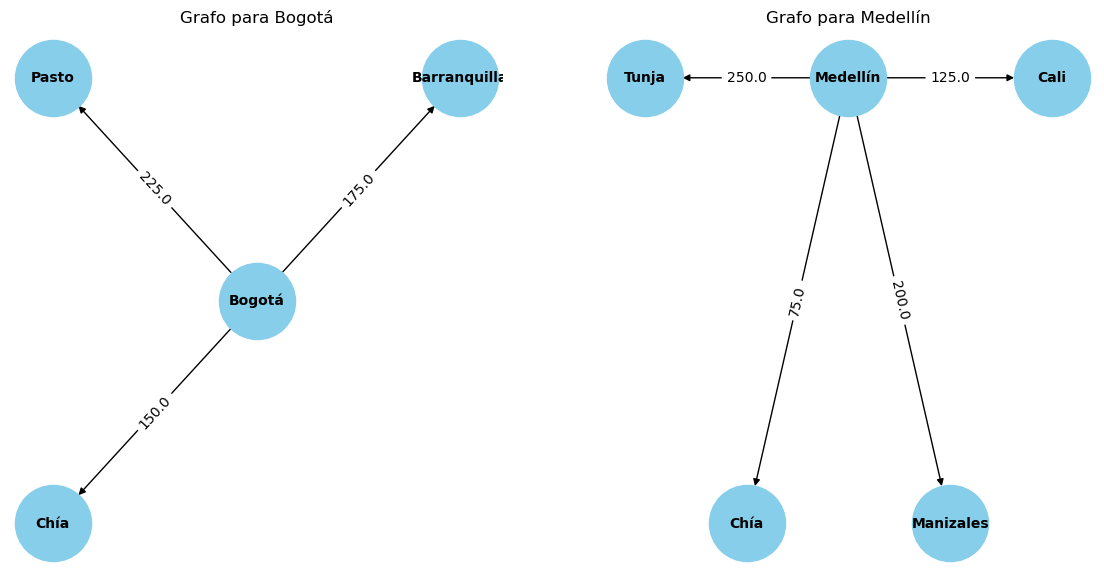

In [38]:
# Nombres de las ciudades
proveedores_nombres = {1: 'Bogotá', 2: 'Medellín'}
destinos_nombres = {1: 'Cali', 2: 'Barranquilla', 3: 'Pasto', 4: 'Tunja', 5: 'Chía', 6: 'Manizales'}

# PLOTTING THE GRAPHS******************************************************************
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Crear subplots

for idx, i in enumerate(provedores):
    G = nx.DiGraph()
    for j in destinos:
        if Model.x[i, j].value > 0:
            G.add_edge(proveedores_nombres[i], destinos_nombres[j], weight=Model.x[i, j].value)
    
    # Crear una disposición personalizada
    pos = {}
    pos[proveedores_nombres[i]] = (0, 0)  # Nodo proveedor en el centro
    angle_step = 360 / numDestinos
    for idx_d, d in enumerate(destinos):
        angle = angle_step * idx_d
        pos[destinos_nombres[d]] = (1 * np.cos(np.radians(angle)), 1 * np.sin(np.radians(angle)))

    edge_labels = nx.get_edge_attributes(G, 'weight')

    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', ax=axes[idx])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[idx])
    axes[idx].set_title(f'Grafo para {proveedores_nombres[i]}')

plt.show()

## **Casos para Analizar**

### Realize un analísis de Sensibilidad de las cuidades de destino y las cuidades de origen.

In [39]:
# Sensitivity analysis: Dual values (Lagrange multipliers)
print("Análisis de sensibilidad")
for i in provedores:
    print(f"Oferta desde origen {proveedores_nombres[i]} = {Model.dual[Model.suministro[i]]:.1f}")
for j in destinos:
    print(f"Demanda en destino {destinos_nombres[j]} = {Model.dual[Model.demanda[j]]:.1f}")

Análisis de sensibilidad
Oferta desde origen Bogotá = -0.2
Oferta desde origen Medellín = 0.0
Demanda en destino Cali = 2.5
Demanda en destino Barranquilla = 2.7
Demanda en destino Pasto = 1.8
Demanda en destino Tunja = 1.0
Demanda en destino Chía = 1.0
Demanda en destino Manizales = 0.8


### Mueva 50 toneladas de oferta de medellin a bogota y repita el analisis de sensibilidad. ¿Que ha cambiado? Recomendaria este cambio or que otro cambio puede proponer

Model unknown

  Variables:
    x : Size=12, Index=[1:2]*[1:6]
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 2) :     0 : 175.0 :  None : False : False : NonNegativeReals
        (1, 3) :     0 : 225.0 :  None : False : False : NonNegativeReals
        (1, 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (1, 5) :     0 : 200.0 :  None : False : False : NonNegativeReals
        (1, 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 1) :     0 : 125.0 :  None : False : False : NonNegativeReals
        (2, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
        (2, 4) :     0 : 250.0 :  None : False : False : NonNegativeReals
        (2, 5) :     0 :  25.0 :  None : False : False : NonNegativeReals
        (2, 6) :     0 : 200.0 :  None : False : False : No

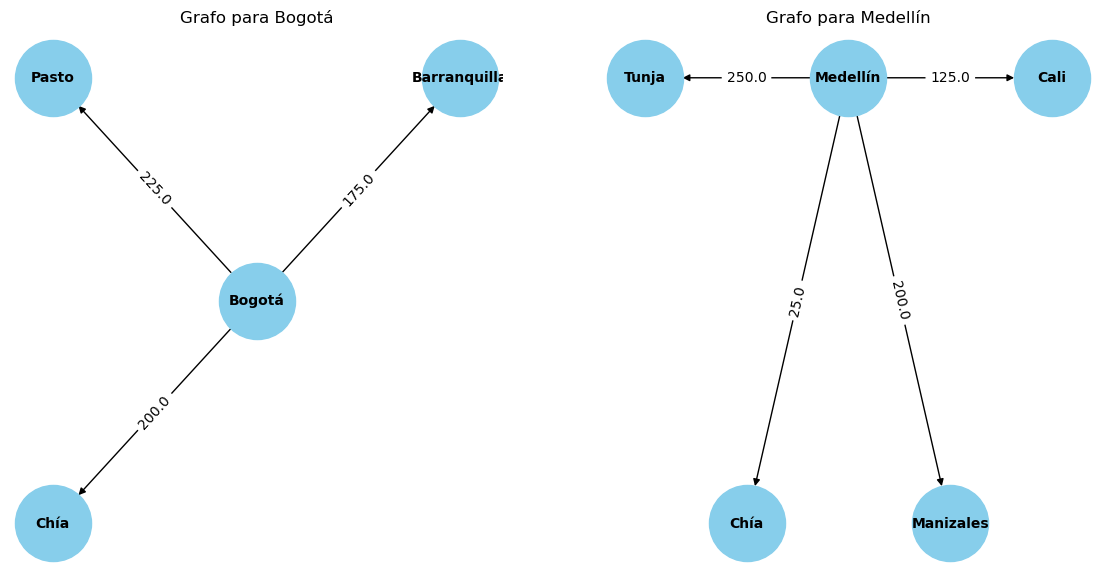

In [40]:
cost={(1,1):999, (1,2):2.5, (1,3):1.6, (1,4):1.4, (1,5):0.8, (1,6):1.4,\
      (2,1):2.5, (2,2):999, (2,3):2.0, (2,4):1.0, (2,5):1.0, (2,6):0.8}

oferta = [600,650]
precioDemanda = [125,175,225,250,225,200]

Model = ConcreteModel()

# SETS & PARAMETERS********************************************************************
numProveedores=2
numDestinos=6

provedores = RangeSet(1,numProveedores)
destinos = RangeSet(1,numDestinos)

Model.x = Var(provedores,destinos, domain=NonNegativeReals)

# OBJECTIVE FUNCTION*******************************************************************
Model.obj = Objective(expr = sum(Model.x[i,j]*cost[i,j] for i in provedores  for j in destinos))

# CONSTRAINTS**************************************************************************
def suministro(Model,i):
    return sum(Model.x[i,j] for j in destinos) <= oferta[i-1]

Model.suministro = Constraint(provedores, rule=suministro)

def demanda(Model,j):
    return sum(Model.x[i,j] for i in provedores) == precioDemanda[j-1]

Model.demanda = Constraint(destinos, rule=demanda)

# APPLYING THE SOLVER******************************************************************
Model.dual = Suffix(direction=Suffix.IMPORT)
SolverFactory('glpk').solve(Model)

Model.display()

# Calcular y mostrar la suma del costo por tonelada
total_cost = sum(Model.x[i, j].value * cost[i, j] for i in provedores for j in destinos)

# Nombres de las ciudades
proveedores_nombres = {1: 'Bogotá', 2: 'Medellín'}
destinos_nombres = {1: 'Cali', 2: 'Barranquilla', 3: 'Pasto', 4: 'Tunja', 5: 'Chía', 6: 'Manizales'}

# PLOTTING THE GRAPHS******************************************************************
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Crear subplots

for idx, i in enumerate(provedores):
    G = nx.DiGraph()
    for j in destinos:
        if Model.x[i, j].value > 0:
            G.add_edge(proveedores_nombres[i], destinos_nombres[j], weight=Model.x[i, j].value)
    
    # Crear una disposición personalizada
    pos = {}
    pos[proveedores_nombres[i]] = (0, 0)  # Nodo proveedor en el centro
    angle_step = 360 / numDestinos
    for idx_d, d in enumerate(destinos):
        angle = angle_step * idx_d
        pos[destinos_nombres[d]] = (1 * np.cos(np.radians(angle)), 1 * np.sin(np.radians(angle)))

    edge_labels = nx.get_edge_attributes(G, 'weight')

    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', ax=axes[idx])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[idx])
    axes[idx].set_title(f'Grafo para {proveedores_nombres[i]}')

plt.show()


# Problema 2: Rutas Óptimas Para Equipos de Inspección de Infraestructura en Colombia

## a. Modelo Matematico:

### Conjuntos:
- **Nodos**:
  $$N = \{0, 1, 2, \dots, n-1\}$$
  Donde \(N\) es el conjunto de localidades (nodos) a inspeccionar. El nodo 0 representa la localidad inicial y final de los equipos.

- **Equipos**:
  $$E = \{1, 2, \dots, e\}$$
  Donde \(E\) es el conjunto de equipos asignados para las inspecciones.

### Parámetros:
- **Matriz de adyacencia**:
  $$C_{ij} = \text{Costo (distancia o tiempo) de desplazarse desde la localidad } i \text{ hacia la localidad } j, \ \forall i, j \in N$$

- **Número de equipos**:
  $$e = \text{Cantidad de equipos disponibles}$$

- **Número de nodos**:
  $$n = \text{Cantidad de nodos (localidades)}$$

### Variables de Decisión:
- **Asignación de rutas**:
  $$x_{ij} = \begin{cases} 
  1 & \text{si el equipo visita la localidad } j \text{ desde la localidad } i \\
  0 & \text{en caso contrario}
  \end{cases}, \ \forall i, j \in N$$
  
- **Posición del nodo**:
  $$u_i = \text{Posición de la localidad } i \text{ en la ruta}, \ \forall i \in N$$

### Función Objetivo:
Minimizar el costo total de desplazamiento de todos los equipos:
$$\text{Minimizar} \quad \sum_{i \in N} \sum_{j \in N} C_{ij} \times x_{ij}$$

### Restricciones:

1. **No autociclos**:
   Un equipo no puede visitar una misma localidad inmediatamente después de haberla dejado:
   $$x_{ii} = 0, \ \forall i \in N$$

2. **Asignación de equipos**:
   Deben salir, como máximo, \(e\) rutas desde el nodo inicial (punto de partida):
   $$\sum_{j \in N} x_{0j} \leq e$$

3. **Retorno de equipos**:
   El número de equipos que salen del nodo inicial debe ser igual al número de equipos que vuelven:
   $$\sum_{i \in N} x_{i0} = \sum_{j \in N} x_{0j}$$

4. **Entrada única por nodo**:
   Cada localidad debe ser visitada exactamente una vez por algún equipo, excepto el nodo inicial:
   $$\sum_{i \in N} x_{ij} = 1, \ \forall j \in N, j \neq 0$$

5. **Salida única por nodo**:
   Desde cada localidad se debe salir una vez:
   $$\sum_{j \in N} x_{ij} = 1, \ \forall i \in N, i \neq 0$$

6. **Eliminación de subtours**:
   Para evitar ciclos no deseados (subtours) en las rutas, se añade la siguiente restricción:
   $$u_i - u_j + n \times x_{ij} \leq n - 1, \ \forall i, j \in N, i \neq j, i \neq 0, j \neq 0$$

## **Casos para Analizar**

### Cantidad de equipos: 1


In [41]:
def obtenerDatos():
    df = pd.read_csv("proof_case.csv", header=None, delimiter=',')
    nodos = df.iloc[0].astype(int)
    matriz = df.iloc[1:].astype(float).values
    return nodos, matriz

#Obtención de los datos del archivo
nodos, matrizDeAdyacencia = obtenerDatos()

# Creación del modelo
M = ConcreteModel()

# Parámetros del modelo
M.numeroDeNodos = Param(within=PositiveIntegers, default=len(nodos))
M.equipos = Param(within=PositiveIntegers, default=1)

# Conjuntos del modelo
M.nodos = RangeSet(0, M.numeroDeNodos - 1)

# Variables de decisión del modelo
M.asignacion = Var(M.nodos, M.nodos, domain=Binary)
M.posicion = Var(M.nodos, domain=NonNegativeIntegers)

# Función objetivo: Minimizar la suma de los arcos seleccionados
M.objetivo = Objective(expr=sum(M.asignacion[i, j] * matrizDeAdyacencia[i, j] for i in M.nodos for j in M.nodos), sense=minimize)

# Restricciones del modelo

# Restricción 1: No se puede ir de un nodo a sí mismo
def autociclo_rule(M, i):
    return M.asignacion[i, i] == 0

M.autociclo = Constraint(M.nodos, rule=autociclo_rule)

# Restricción 2: Si hay e equipos, entonces deben haber, a lo mucho, e arcos seleccionados que empiecen en el nodo 0
def equiposSalientes_rule(M):
    return sum(M.asignacion[0, j] for j in M.nodos) <= M.equipos

M.equiposSalientes = Constraint(rule=equiposSalientes_rule)

# Restricción 3: Si hay e equipos que salen del nodo 0, entonces debe haber e equipos que entran al nodo 0
def equiposEntrantes_rule(M):
    return sum(M.asignacion[i, 0] for i in M.nodos) == sum(M.asignacion[0, j] for j in M.nodos)

M.equiposEntrantes = Constraint(rule=equiposEntrantes_rule)

# Restricción 4: Se debe entrar una vez en cada nodo
def unicaEntrada_rule(M, j):
    if j != 0:
        return sum(M.asignacion[i, j] for i in M.nodos) == 1
    return Constraint.Skip

M.unicaEntrada = Constraint(M.nodos, rule=unicaEntrada_rule)

# Restricción 5: Se debe salir una vez de cada nodo
def unicaSalida_rule(M, i):
    if i != 0:
        return sum(M.asignacion[i, j] for j in M.nodos) == 1
    return Constraint.Skip

M.unicaSalida = Constraint(M.nodos, rule=unicaSalida_rule)

# Restricción 6: Eliminación de subtours
def subtours_rule(M, i, j):
    if i != j and min(i, j) != 0:
        return M.posicion[i] - M.posicion[j] + M.numeroDeNodos * M.asignacion[i, j] <= M.numeroDeNodos - 1
    return Constraint.Skip

M.subtours = Constraint(M.nodos, M.nodos, rule=subtours_rule)


SolverFactory('glpk').solve(M)
M.display()

Model unknown

  Variables:
    asignacion : Size=36, Index=nodos*nodos
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :

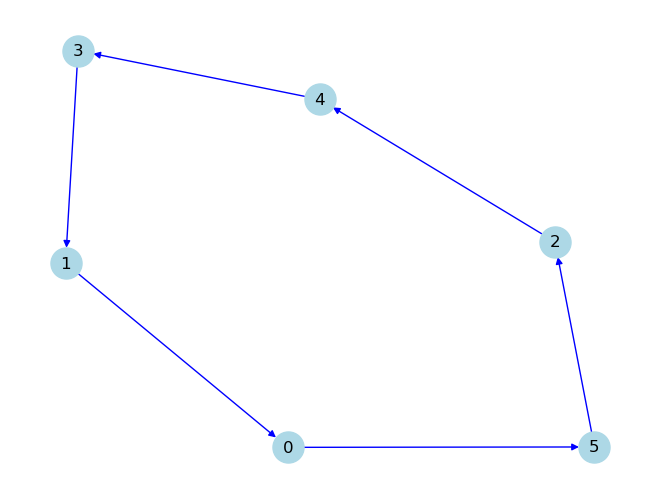

In [42]:
def crearGrafo(M):
    grafo = nx.DiGraph()
    for nodo in nodos:
        grafo.add_node(nodo)
    for i in M.nodos:
        for j in M.nodos:
            if M.asignacion[i, j].value == 1:
                grafo.add_edge(i, j, color='blue')
    return grafo


def graficarMTSP(M):
    grafo = crearGrafo(M)
    pos = nx.spring_layout(grafo)
    plt.figure()
    nx.draw(grafo, pos, edge_color='blue', with_labels=True, node_size=500, node_color='lightblue')
    plt.show()


graficarMTSP(M)

### Cantidad de equipos: 2

In [43]:
def obtenerDatos():
    df = pd.read_csv("proof_case.csv", header=None, delimiter=',')
    nodos = df.iloc[0].astype(int)
    matriz = df.iloc[1:].astype(float).values
    return nodos, matriz

#Obtención de los datos del archivo
nodos, matrizDeAdyacencia = obtenerDatos()

# Creación del modelo
M = ConcreteModel()

# Parámetros del modelo
M.numeroDeNodos = Param(within=PositiveIntegers, default=len(nodos))
M.equipos = Param(within=PositiveIntegers, default=2)

# Conjuntos del modelo
M.nodos = RangeSet(0, M.numeroDeNodos - 1)

# Variables de decisión del modelo
M.asignacion = Var(M.nodos, M.nodos, domain=Binary)
M.posicion = Var(M.nodos, domain=NonNegativeIntegers)

# Función objetivo: Minimizar la suma de los arcos seleccionados
M.objetivo = Objective(expr=sum(M.asignacion[i, j] * matrizDeAdyacencia[i, j] for i in M.nodos for j in M.nodos), sense=minimize)

# Restricciones del modelo

# Restricción 1: No se puede ir de un nodo a sí mismo
def autociclo_rule(M, i):
    return M.asignacion[i, i] == 0

M.autociclo = Constraint(M.nodos, rule=autociclo_rule)

# Restricción 2: Si hay e equipos, entonces deben haber, a lo mucho, e arcos seleccionados que empiecen en el nodo 0
def equiposSalientes_rule(M):
    return sum(M.asignacion[0, j] for j in M.nodos) <= M.equipos

M.equiposSalientes = Constraint(rule=equiposSalientes_rule)

# Restricción 3: Si hay e equipos que salen del nodo 0, entonces debe haber e equipos que entran al nodo 0
def equiposEntrantes_rule(M):
    return sum(M.asignacion[i, 0] for i in M.nodos) == sum(M.asignacion[0, j] for j in M.nodos)

M.equiposEntrantes = Constraint(rule=equiposEntrantes_rule)

# Restricción 4: Se debe entrar una vez en cada nodo
def unicaEntrada_rule(M, j):
    if j != 0:
        return sum(M.asignacion[i, j] for i in M.nodos) == 1
    return Constraint.Skip

M.unicaEntrada = Constraint(M.nodos, rule=unicaEntrada_rule)

# Restricción 5: Se debe salir una vez de cada nodo
def unicaSalida_rule(M, i):
    if i != 0:
        return sum(M.asignacion[i, j] for j in M.nodos) == 1
    return Constraint.Skip

M.unicaSalida = Constraint(M.nodos, rule=unicaSalida_rule)

# Restricción 6: Eliminación de subtours
def subtours_rule(M, i, j):
    if i != j and min(i, j) != 0:
        return M.posicion[i] - M.posicion[j] + M.numeroDeNodos * M.asignacion[i, j] <= M.numeroDeNodos - 1
    return Constraint.Skip

M.subtours = Constraint(M.nodos, M.nodos, rule=subtours_rule)


SolverFactory('glpk').solve(M)
M.display()

Model unknown

  Variables:
    asignacion : Size=36, Index=nodos*nodos
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :

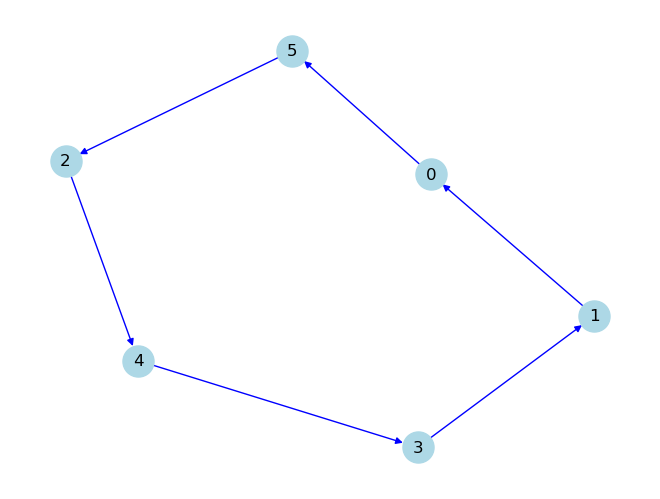

In [44]:
def crearGrafo(M):
    grafo = nx.DiGraph()
    for nodo in nodos:
        grafo.add_node(nodo)
    for i in M.nodos:
        for j in M.nodos:
            if M.asignacion[i, j].value == 1:
                grafo.add_edge(i, j, color='blue')
    return grafo


def graficarMTSP(M):
    grafo = crearGrafo(M)
    pos = nx.spring_layout(grafo)
    plt.figure()
    nx.draw(grafo, pos, edge_color='blue', with_labels=True, node_size=500, node_color='lightblue')
    plt.show()


graficarMTSP(M)

### Cantidad de equipos: 3

In [45]:
def obtenerDatos():
    df = pd.read_csv("proof_case.csv", header=None, delimiter=',')
    nodos = df.iloc[0].astype(int)
    matriz = df.iloc[1:].astype(float).values
    return nodos, matriz

#Obtención de los datos del archivo
nodos, matrizDeAdyacencia = obtenerDatos()

# Creación del modelo
M = ConcreteModel()

# Parámetros del modelo
M.numeroDeNodos = Param(within=PositiveIntegers, default=len(nodos))
M.equipos = Param(within=PositiveIntegers, default=3)

# Conjuntos del modelo
M.nodos = RangeSet(0, M.numeroDeNodos - 1)

# Variables de decisión del modelo
M.asignacion = Var(M.nodos, M.nodos, domain=Binary)
M.posicion = Var(M.nodos, domain=NonNegativeIntegers)

# Función objetivo: Minimizar la suma de los arcos seleccionados
M.objetivo = Objective(expr=sum(M.asignacion[i, j] * matrizDeAdyacencia[i, j] for i in M.nodos for j in M.nodos), sense=minimize)

# Restricciones del modelo

# Restricción 1: No se puede ir de un nodo a sí mismo
def autociclo_rule(M, i):
    return M.asignacion[i, i] == 0

M.autociclo = Constraint(M.nodos, rule=autociclo_rule)

# Restricción 2: Si hay e equipos, entonces deben haber, a lo mucho, e arcos seleccionados que empiecen en el nodo 0
def equiposSalientes_rule(M):
    return sum(M.asignacion[0, j] for j in M.nodos) <= M.equipos

M.equiposSalientes = Constraint(rule=equiposSalientes_rule)

# Restricción 3: Si hay e equipos que salen del nodo 0, entonces debe haber e equipos que entran al nodo 0
def equiposEntrantes_rule(M):
    return sum(M.asignacion[i, 0] for i in M.nodos) == sum(M.asignacion[0, j] for j in M.nodos)

M.equiposEntrantes = Constraint(rule=equiposEntrantes_rule)

# Restricción 4: Se debe entrar una vez en cada nodo
def unicaEntrada_rule(M, j):
    if j != 0:
        return sum(M.asignacion[i, j] for i in M.nodos) == 1
    return Constraint.Skip

M.unicaEntrada = Constraint(M.nodos, rule=unicaEntrada_rule)

# Restricción 5: Se debe salir una vez de cada nodo
def unicaSalida_rule(M, i):
    if i != 0:
        return sum(M.asignacion[i, j] for j in M.nodos) == 1
    return Constraint.Skip

M.unicaSalida = Constraint(M.nodos, rule=unicaSalida_rule)

# Restricción 6: Eliminación de subtours
def subtours_rule(M, i, j):
    if i != j and min(i, j) != 0:
        return M.posicion[i] - M.posicion[j] + M.numeroDeNodos * M.asignacion[i, j] <= M.numeroDeNodos - 1
    return Constraint.Skip

M.subtours = Constraint(M.nodos, M.nodos, rule=subtours_rule)


SolverFactory('glpk').solve(M)
M.display()

Model unknown

  Variables:
    asignacion : Size=36, Index=nodos*nodos
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :

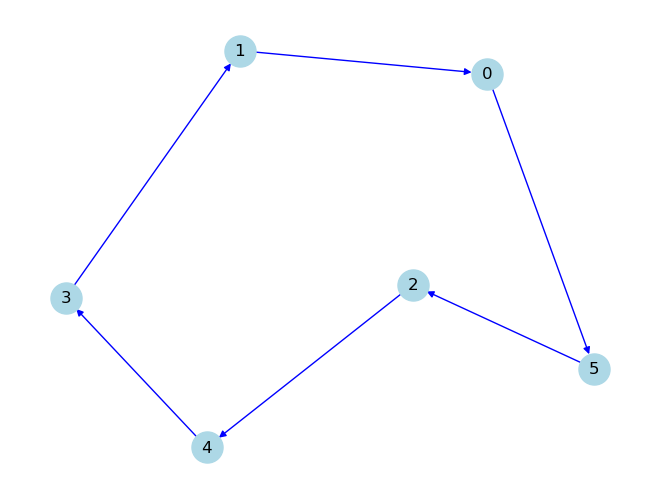

In [46]:
def crearGrafo(M):
    grafo = nx.DiGraph()
    for nodo in nodos:
        grafo.add_node(nodo)
    for i in M.nodos:
        for j in M.nodos:
            if M.asignacion[i, j].value == 1:
                grafo.add_edge(i, j, color='blue')
    return grafo


def graficarMTSP(M):
    grafo = crearGrafo(M)
    pos = nx.spring_layout(grafo)
    plt.figure()
    nx.draw(grafo, pos, edge_color='blue', with_labels=True, node_size=500, node_color='lightblue')
    plt.show()


graficarMTSP(M)

### Cantidad de equipos: 5

In [47]:
def obtenerDatos():
    df = pd.read_csv("proof_case.csv", header=None, delimiter=',')
    nodos = df.iloc[0].astype(int)
    matriz = df.iloc[1:].astype(float).values
    return nodos, matriz

#Obtención de los datos del archivo
nodos, matrizDeAdyacencia = obtenerDatos()

# Creación del modelo
M = ConcreteModel()

# Parámetros del modelo
M.numeroDeNodos = Param(within=PositiveIntegers, default=len(nodos))
M.equipos = Param(within=PositiveIntegers, default=5)

# Conjuntos del modelo
M.nodos = RangeSet(0, M.numeroDeNodos - 1)

# Variables de decisión del modelo
M.asignacion = Var(M.nodos, M.nodos, domain=Binary)
M.posicion = Var(M.nodos, domain=NonNegativeIntegers)

# Función objetivo: Minimizar la suma de los arcos seleccionados
M.objetivo = Objective(expr=sum(M.asignacion[i, j] * matrizDeAdyacencia[i, j] for i in M.nodos for j in M.nodos), sense=minimize)

# Restricciones del modelo

# Restricción 1: No se puede ir de un nodo a sí mismo
def autociclo_rule(M, i):
    return M.asignacion[i, i] == 0

M.autociclo = Constraint(M.nodos, rule=autociclo_rule)

# Restricción 2: Si hay e equipos, entonces deben haber, a lo mucho, e arcos seleccionados que empiecen en el nodo 0
def equiposSalientes_rule(M):
    return sum(M.asignacion[0, j] for j in M.nodos) <= M.equipos

M.equiposSalientes = Constraint(rule=equiposSalientes_rule)

# Restricción 3: Si hay e equipos que salen del nodo 0, entonces debe haber e equipos que entran al nodo 0
def equiposEntrantes_rule(M):
    return sum(M.asignacion[i, 0] for i in M.nodos) == sum(M.asignacion[0, j] for j in M.nodos)

M.equiposEntrantes = Constraint(rule=equiposEntrantes_rule)

# Restricción 4: Se debe entrar una vez en cada nodo
def unicaEntrada_rule(M, j):
    if j != 0:
        return sum(M.asignacion[i, j] for i in M.nodos) == 1
    return Constraint.Skip

M.unicaEntrada = Constraint(M.nodos, rule=unicaEntrada_rule)

# Restricción 5: Se debe salir una vez de cada nodo
def unicaSalida_rule(M, i):
    if i != 0:
        return sum(M.asignacion[i, j] for j in M.nodos) == 1
    return Constraint.Skip

M.unicaSalida = Constraint(M.nodos, rule=unicaSalida_rule)

# Restricción 6: Eliminación de subtours
def subtours_rule(M, i, j):
    if i != j and min(i, j) != 0:
        return M.posicion[i] - M.posicion[j] + M.numeroDeNodos * M.asignacion[i, j] <= M.numeroDeNodos - 1
    return Constraint.Skip

M.subtours = Constraint(M.nodos, M.nodos, rule=subtours_rule)


SolverFactory('glpk').solve(M)
M.display()

Model unknown

  Variables:
    asignacion : Size=36, Index=nodos*nodos
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :

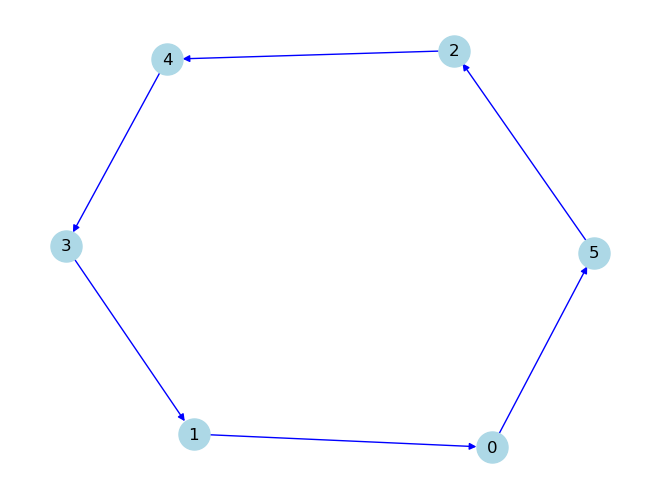

In [48]:
def crearGrafo(M):
    grafo = nx.DiGraph()
    for nodo in nodos:
        grafo.add_node(nodo)
    for i in M.nodos:
        for j in M.nodos:
            if M.asignacion[i, j].value == 1:
                grafo.add_edge(i, j, color='blue')
    return grafo


def graficarMTSP(M):
    grafo = crearGrafo(M)
    pos = nx.spring_layout(grafo)
    plt.figure()
    nx.draw(grafo, pos, edge_color='blue', with_labels=True, node_size=500, node_color='lightblue')
    plt.show()


graficarMTSP(M)

### Cantidad de equipos: 8

In [49]:
def obtenerDatos():
    df = pd.read_csv("proof_case.csv", header=None, delimiter=',')
    nodos = df.iloc[0].astype(int)
    matriz = df.iloc[1:].astype(float).values
    return nodos, matriz

#Obtención de los datos del archivo
nodos, matrizDeAdyacencia = obtenerDatos()

# Creación del modelo
M = ConcreteModel()

# Parámetros del modelo
M.numeroDeNodos = Param(within=PositiveIntegers, default=len(nodos))
M.equipos = Param(within=PositiveIntegers, default=8)

# Conjuntos del modelo
M.nodos = RangeSet(0, M.numeroDeNodos - 1)

# Variables de decisión del modelo
M.asignacion = Var(M.nodos, M.nodos, domain=Binary)
M.posicion = Var(M.nodos, domain=NonNegativeIntegers)

# Función objetivo: Minimizar la suma de los arcos seleccionados
M.objetivo = Objective(expr=sum(M.asignacion[i, j] * matrizDeAdyacencia[i, j] for i in M.nodos for j in M.nodos), sense=minimize)

# Restricciones del modelo

# Restricción 1: No se puede ir de un nodo a sí mismo
def autociclo_rule(M, i):
    return M.asignacion[i, i] == 0

M.autociclo = Constraint(M.nodos, rule=autociclo_rule)

# Restricción 2: Si hay e equipos, entonces deben haber, a lo mucho, e arcos seleccionados que empiecen en el nodo 0
def equiposSalientes_rule(M):
    return sum(M.asignacion[0, j] for j in M.nodos) <= M.equipos

M.equiposSalientes = Constraint(rule=equiposSalientes_rule)

# Restricción 3: Si hay e equipos que salen del nodo 0, entonces debe haber e equipos que entran al nodo 0
def equiposEntrantes_rule(M):
    return sum(M.asignacion[i, 0] for i in M.nodos) == sum(M.asignacion[0, j] for j in M.nodos)

M.equiposEntrantes = Constraint(rule=equiposEntrantes_rule)

# Restricción 4: Se debe entrar una vez en cada nodo
def unicaEntrada_rule(M, j):
    if j != 0:
        return sum(M.asignacion[i, j] for i in M.nodos) == 1
    return Constraint.Skip

M.unicaEntrada = Constraint(M.nodos, rule=unicaEntrada_rule)

# Restricción 5: Se debe salir una vez de cada nodo
def unicaSalida_rule(M, i):
    if i != 0:
        return sum(M.asignacion[i, j] for j in M.nodos) == 1
    return Constraint.Skip

M.unicaSalida = Constraint(M.nodos, rule=unicaSalida_rule)

# Restricción 6: Eliminación de subtours
def subtours_rule(M, i, j):
    if i != j and min(i, j) != 0:
        return M.posicion[i] - M.posicion[j] + M.numeroDeNodos * M.asignacion[i, j] <= M.numeroDeNodos - 1
    return Constraint.Skip

M.subtours = Constraint(M.nodos, M.nodos, rule=subtours_rule)


SolverFactory('glpk').solve(M)
M.display()

Model unknown

  Variables:
    asignacion : Size=36, Index=nodos*nodos
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (0, 4) :     0 :   0.0 :     1 : False : False : Binary
        (0, 5) :     0 :   1.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 4) :     0 :   0.0 :     1 : False : False : Binary
        (1, 5) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :

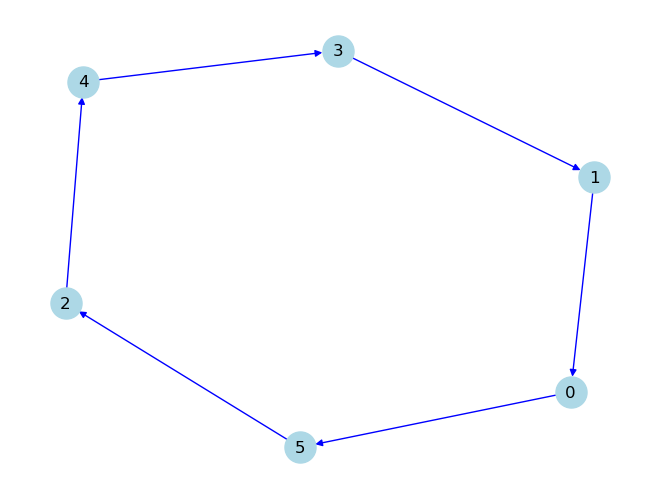

In [50]:
def crearGrafo(M):
    grafo = nx.DiGraph()
    for nodo in nodos:
        grafo.add_node(nodo)
    for i in M.nodos:
        for j in M.nodos:
            if M.asignacion[i, j].value == 1:
                grafo.add_edge(i, j, color='blue')
    return grafo


def graficarMTSP(M):
    grafo = crearGrafo(M)
    pos = nx.spring_layout(grafo)
    plt.figure()
    nx.draw(grafo, pos, edge_color='blue', with_labels=True, node_size=500, node_color='lightblue')
    plt.show()


graficarMTSP(M)

# Problema 3: Optimización de Sensores en Ciudades Inteligentes

## a. Modelo Matemático

### Conjuntos:
- **Lugares**:
  $$I = \{1, 2, \dots, 12\}$$  
  Donde \(I\) es el conjunto de lugares posibles para instalar sensores.

- **Sensores**:
  $$J = \{1, 2, 3\}$$  
  Donde \(J\) es el conjunto de tipos de sensores disponibles.

### Parámetros:
- **Cobertura de zona por sensor**:
  $$\text{zone\_coverage}_{k,j} = \begin{cases} 
  1 & \text{si el lugar } k \text{ está cubierto por el sensor } j \\
  0 & \text{en caso contrario}
  \end{cases}, \ \forall k \in I, \ \forall j \in J$$

- **Cobertura del sensor en un lugar específico**:
  $$\text{sensor\_coverage}_{i,j} = \begin{cases} 
  1 & \text{si el sensor } j \text{ puede ser instalado en el lugar } i \\
  0 & \text{en caso contrario}
  \end{cases}, \ \forall i \in I, \forall j \in J$$

- **Consumo de energía**:
  $$\text{energy\_consumption}_j = \text{Consumo de energía del sensor } j, \ \forall j \in J$$

- **Costo de comunicación**:
  $$\text{communication\_cost}_{i,j} = \text{Costo de comunicación del sensor } j \text{ en el lugar } i, \ \forall i \in I, \forall j \in J$$

- **Costo de instalación**:
  $$\text{installation\_cost}_i = \text{Costo de instalación en el lugar } i, \ \forall i \in I$$

### Variables de Decisión:
- **Selección de lugar para instalar un sensor**:
  $$x_i = \begin{cases} 
  1 & \text{si se selecciona el lugar } i \text{ para instalar un sensor} \\
  0 & \text{en caso contrario}
  \end{cases}, \ \forall i \in I$$

- **Instalación de un sensor en un lugar**:
  $$s_{i,j} = \begin{cases} 
  1 & \text{si se instala el sensor } j \text{ en el lugar } i \\
  0 & \text{en caso contrario}
  \end{cases}, \ \forall i \in I, \forall j \in J$$

### Función Objetivo:
Minimizar el costo total que incluye el consumo de energía, los costos de comunicación y los costos de instalación:
$$
\text{Minimizar} \quad \sum_{i \in I} \sum_{j \in J} \left( s_{i,j} \times \left( \text{energy\_consumption}_j + \text{communication\_cost}_{i,j} + \text{installation\_cost}_i \right) \right)
$$

### Restricciones:

1. **Cobertura Completa**:
   Un sensor debe cubrir completamente una localidad si está instalado en ella:
   $$\sum_{j \in J} \text{sensor\_coverage}_{i, j} \cdot s_{ij} \leq 1, \quad \forall i \in I$$

2. **Cobertura de Zonas**:
   Cada zona debe ser cubierta por al menos un sensor instalado en las localidades:
   $$\sum_{j \in J} \text{zone\_coverage}_{k, i} \cdot x_i \geq 1, \quad \forall k \in I$$

3. **Instalación de Sensores**:
   Si una localidad es seleccionada, debe tener al menos un sensor instalado:
   $$\sum_{j \in J} s_{ij} \geq x_i, \quad \forall i \in I$$

4. **Instalación Restringida por Cobertura**:
   Solo se puede instalar un sensor en una localidad si puede cubrir esa localidad:
   $$s_{ij} \leq \text{sensor\_coverage}_{i, j}, \quad \forall i \in I, \forall j \in J$$

5. **Sensores en Lugares Adyacentes**:
   Si una localidad no es seleccionada, debe tener al menos un sensor compatible en una localidad adyacente:
   $$\sum_{k \in I} \sum_{j \in J} \left( \text{zone\_coverage}_{k, i} \cdot \text{sensor\_coverage}_{i, j} \cdot s_{kj} \right) \geq 1, \quad \forall i \in I$$


In [51]:
def leerSensorCoverage(filename):
    C = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader) 
        for i, row in enumerate(reader, start=1):
            C[i] = list(map(int, row[1:]))
    return C

def leerConsumoEnergia(filename):
    energy_consumption = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  
        for row in reader:
            energy_consumption.append(int(row[1]))
    return energy_consumption

def leerCostosComunicacion(filename):
    communication_cost = {} 
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  
        temp_costs = {}
        for row in reader:
            location = int(row[0][1:])  
            sensor_type = row[1] 
            cost = int(row[2]) 
            if location not in temp_costs:
                temp_costs[location] = []
            temp_costs[location].append(cost)
        communication_cost = temp_costs
    return communication_cost

def leerCostosInstalacion(filename):
    installation_cost = []
    
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)  
        for row in reader:
            cost = int(row[1]) 
            installation_cost.append(cost)
    
    return installation_cost
# Parámetros
zone_coverage = {
    (1, 1): 1, (1, 2): 1, (1, 3): 1, (1, 4): 0, (1, 5): 1, (1, 6): 0, (1, 7): 0, (1, 8): 0, (1, 9): 0, (1, 10): 0, (1, 11): 0, (1, 12): 0,
    (2, 1): 1, (2, 2): 1, (2, 3): 0, (2, 4): 0, (2, 5): 1, (2, 6): 0, (2, 7): 0, (2, 8): 0, (2, 9): 0, (2, 10): 0, (2, 11): 0, (2, 12): 0,
    (3, 1): 1, (3, 2): 0, (3, 3): 1, (3, 4): 1, (3, 5): 1, (3, 6): 1, (3, 7): 1, (3, 8): 1, (3, 9): 0, (3, 10): 0, (3, 11): 0, (3, 12): 0,
    (4, 1): 0, (4, 2): 0, (4, 3): 1, (4, 4): 1, (4, 5): 1, (4, 6): 1, (4, 7): 1, (4, 8): 0, (4, 9): 0, (4, 10): 0, (4, 11): 1, (4, 12): 0,
    (5, 1): 1, (5, 2): 1, (5, 3): 0, (5, 4): 1, (5, 5): 1, (5, 6): 0, (5, 7): 0, (5, 8): 1, (5, 9): 0, (5, 10): 1, (5, 11): 1, (5, 12): 0,
    (6, 1): 0, (6, 2): 0, (6, 3): 1, (6, 4): 1, (6, 5): 0, (6, 6): 1, (6, 7): 0, (6, 8): 1, (6, 9): 0, (6, 10): 0, (6, 11): 1, (6, 12): 0,
    (7, 1): 0, (7, 2): 0, (7, 3): 1, (7, 4): 1, (7, 5): 0, (7, 6): 0, (7, 7): 1, (7, 8): 1, (7, 9): 0, (7, 10): 1, (7, 11): 0, (7, 12): 1,
    (8, 1): 0, (8, 2): 0, (8, 3): 1, (8, 4): 0, (8, 5): 0, (8, 6): 1, (8, 7): 1, (8, 8): 1, (8, 9): 1, (8, 10): 0, (8, 11): 1, (8, 12): 1,
    (9, 1): 0, (9, 2): 0, (9, 3): 0, (9, 4): 0, (9, 5): 0, (9, 6): 0, (9, 7): 0, (9, 8): 1, (9, 9): 1, (9, 10): 1, (9, 11): 1, (9, 12): 1,
    (10, 1): 0, (10, 2): 0, (10, 3): 0, (10, 4): 0, (10, 5): 1, (10, 6): 0, (10, 7): 0, (10, 8): 0, (10, 9): 1, (10, 10): 1, (10, 11): 1, (10, 12): 0,
    (11, 1): 0, (11, 2): 0, (11, 3): 0, (11, 4): 1, (11, 5): 1, (11, 6): 1, (11, 7): 0, (11, 8): 1, (11, 9): 1, (11, 10): 1, (11, 11): 1, (11, 12): 0,
    (12, 1): 0, (12, 2): 0, (12, 3): 0, (12, 4): 0, (12, 5): 0, (12, 6): 0, (12, 7): 1, (12, 8): 1, (12, 9): 1, (12, 10): 0, (12, 11): 0, (12, 12): 1
}


sensor_coverage = leerSensorCoverage("sensor_coverage.csv")

energy_consumption = leerConsumoEnergia("energy_consumption.csv")

communication_cost = leerCostosComunicacion("communication_costs.csv")

installation_cost = leerCostosInstalacion("installation_costs.csv")

In [52]:
# Crear modelo
model = ConcreteModel()

# Conjuntos
model.I = Set(initialize=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])  # Lugares
model.J = Set(initialize=[1, 2, 3])  # Sensores

# Variables de decisión
model.x = Var(model.I, within=Binary)  
model.s = Var(model.I, model.J, within=Binary) 

def full_coverage_rule(model, i):
    return sum(sensor_coverage[i][j-1] * model.s[i, j] for j in model.J) <=1
model.full_coverage = Constraint(model.I, rule=full_coverage_rule)

# Restricciones de cobertura de zonas
def cover_zones_rule(model, k):
    return sum(zone_coverage[k, j] * model.x[j] for j in model.I ) >= 1 
model.cover_zones = Constraint(model.I, rule=cover_zones_rule)

# Restricción de que si un lugar es seleccionado, debe tener al menos un sensor instalado
def ensure_sensor_installed_rule(model, i):
    return  sum(model.s[i, j] for j in model.J) >= model.x[i]
model.ensure_sensor_installed = Constraint(model.I, rule=ensure_sensor_installed_rule)

# Nueva restricción: solo se puede poner un sensor en un lugar si C[i][j-1] == 1
def sensor_installation_rule(model, i, j):
    return model.s[i, j] <= sensor_coverage[i][j-1]
model.sensor_installation = Constraint(model.I, model.J, rule=sensor_installation_rule)

# Restricción: Si un lugar no es seleccionado, debe tener al menos un sensor compatible en un lugar adyacente
def sensor_nearby_rule(model, i):
    return sum(model.s[k, j] * zone_coverage[k, i] * sensor_coverage[i][j-1] for k in model.I for j in model.J) >= 1
model.sensor_nearby = Constraint(model.I, rule=sensor_nearby_rule)



def objective_function(model):
    return (sum(model.s[l, s] * energy_consumption[s-1] for l in model.I for s in model.J) + 
            sum(model.s[l, s] * communication_cost[l][s-1] for l in model.I for s in model.J) + 
            sum(model.s[l, s]* installation_cost[l-1] for l in model.I for s in model.J))

model.obj = Objective(rule=objective_function, sense=minimize)

solver = SolverFactory('glpk')
results = solver.solve(model)

model.display()


Model unknown

  Variables:
    x : Size=12, Index=I
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   0.0 :     1 : False : False : Binary
         11 :     0 :   1.0 :     1 : False : False : Binary
         12 :     0 :   0.0 :     1 : False : False : Binary
    s : Size=36, Index=I*J
        Key     : Lower : Value : Upper : Fixed : Stale : Domain
         (1, 1) :     0 :   0.0 :     1 : False : False : Bina

In [53]:
# Mostrar resultados
for i in model.I:
    if model.x[i].value > 0:
        print(f"Lugar {i} seleccionado: {model.x[i].value}")
        adyacentes = [k for k in model.I if zone_coverage.get((i, k), 0) == 1]
        print(f"  Lugares adyacentes: {adyacentes}")
        for j in model.J:
            if model.s[i, j].value > 0:
                print(f"  Sensor {j} en lugar {i}: {model.s[i, j].value}")
                cubiertos = [k for k in adyacentes if sensor_coverage[k][j-1] == 1]
                print(f"    Cubre los lugares adyacentes: {cubiertos}")

Lugar 2 seleccionado: 1.0
  Lugares adyacentes: [1, 2, 5]
  Sensor 3 en lugar 2: 1.0
    Cubre los lugares adyacentes: [1, 2, 5]
Lugar 8 seleccionado: 1.0
  Lugares adyacentes: [3, 6, 7, 8, 9, 11, 12]
  Sensor 1 en lugar 8: 1.0
    Cubre los lugares adyacentes: [3, 6, 7, 8, 9, 11, 12]
Lugar 11 seleccionado: 1.0
  Lugares adyacentes: [4, 5, 6, 8, 9, 10, 11]
  Sensor 1 en lugar 11: 1.0
    Cubre los lugares adyacentes: [4, 5, 6, 8, 9, 10, 11]


## **Casos para Analizar**

### Corra el modelo unicamente teniendo en cuenta el costo de instalación en la función objetivo. ¿Como cambia la solución?


In [54]:
# Crear modelo
model = ConcreteModel()

# Conjuntos
model.I = Set(initialize=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])  # Lugares
model.J = Set(initialize=[1, 2, 3])  # Sensores

# Variables de decisión
model.x = Var(model.I, within=Binary)  
model.s = Var(model.I, model.J, within=Binary) 

def full_coverage_rule(model, i):
    return sum(sensor_coverage[i][j-1] * model.s[i, j] for j in model.J) <=1
model.full_coverage = Constraint(model.I, rule=full_coverage_rule)

# Restricciones de cobertura de zonas
def cover_zones_rule(model, k):
    return sum(zone_coverage[k, j] * model.x[j] for j in model.I ) >= 1 
model.cover_zones = Constraint(model.I, rule=cover_zones_rule)

# Restricción de que si un lugar es seleccionado, debe tener al menos un sensor instalado
def ensure_sensor_installed_rule(model, i):
    return  sum(model.s[i, j] for j in model.J) >= model.x[i]
model.ensure_sensor_installed = Constraint(model.I, rule=ensure_sensor_installed_rule)

# Nueva restricción: solo se puede poner un sensor en un lugar si C[i][j-1] == 1
def sensor_installation_rule(model, i, j):
    return model.s[i, j] <= sensor_coverage[i][j-1]
model.sensor_installation = Constraint(model.I, model.J, rule=sensor_installation_rule)

# Restricción: Si un lugar no es seleccionado, debe tener al menos un sensor compatible en un lugar adyacente
def sensor_nearby_rule(model, i):
    return sum(model.s[k, j] * zone_coverage[k, i] * sensor_coverage[i][j-1] for k in model.I for j in model.J) >= 1
model.sensor_nearby = Constraint(model.I, rule=sensor_nearby_rule)



def objective_function(model):
    #Solo se tiene en cuenta el costo de instalación
    return ( sum(model.s[l, s]* installation_cost[l-1] for l in model.I for s in model.J))

model.obj = Objective(rule=objective_function, sense=minimize)

solver = SolverFactory('glpk')
results = solver.solve(model)

model.display()

Model unknown

  Variables:
    x : Size=12, Index=I
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   0.0 :     1 : False : False : Binary
          4 :     0 :   0.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   0.0 :     1 : False : False : Binary
          8 :     0 :   1.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary
         10 :     0 :   0.0 :     1 : False : False : Binary
         11 :     0 :   1.0 :     1 : False : False : Binary
         12 :     0 :   0.0 :     1 : False : False : Binary
    s : Size=36, Index=I*J
        Key     : Lower : Value : Upper : Fixed : Stale : Domain
         (1, 1) :     0 :   0.0 :     1 : False : False : Bina

In [55]:
# Mostrar resultados
for i in model.I:
    if model.x[i].value > 0:
        print(f"Lugar {i} seleccionado: {model.x[i].value}")
        adyacentes = [k for k in model.I if zone_coverage.get((i, k), 0) == 1]
        print(f"  Lugares adyacentes: {adyacentes}")
        for j in model.J:
            if model.s[i, j].value > 0:
                print(f"  Sensor {j} en lugar {i}: {model.s[i, j].value}")
                cubiertos = [k for k in adyacentes if sensor_coverage[k][j-1] == 1]
                print(f"    Cubre los lugares adyacentes: {cubiertos}")

Lugar 2 seleccionado: 1.0
  Lugares adyacentes: [1, 2, 5]
  Sensor 1 en lugar 2: 1.0
    Cubre los lugares adyacentes: [1, 2, 5]
Lugar 8 seleccionado: 1.0
  Lugares adyacentes: [3, 6, 7, 8, 9, 11, 12]
  Sensor 1 en lugar 8: 1.0
    Cubre los lugares adyacentes: [3, 6, 7, 8, 9, 11, 12]
Lugar 11 seleccionado: 1.0
  Lugares adyacentes: [4, 5, 6, 8, 9, 10, 11]
  Sensor 1 en lugar 11: 1.0
    Cubre los lugares adyacentes: [4, 5, 6, 8, 9, 10, 11]
